In [11]:
import importlib
import xarray as xr
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

from ecpaper_utils import jlat_utils as jlat
from ecpaper_utils import bootstrap_utils as boot
from ecpaper_utils import filter_utils as filt
from ecpaper_utils import averaging_utils as avg

importlib.reload(jlat)
importlib.reload(boot)
importlib.reload(filt)

import warnings
warnings.filterwarnings('ignore')

In [2]:
modnames=['CanESM2','CESM1-CAM5','CSIRO-Mk3-6-0','GFDL-CM3','MPI-ESM']
datadir="/project/cas/islas/python/ecpaper2020/DATASORT/VWIND/DATA/"

Generate histograms and bootstrapping estimates fo the standard deviations for each MMLEA model

In [101]:
datadict={}
binsp=np.arange(-1.2,1.3,0.05)
binsdif=np.arange(-3,3.1,0.1)

histopast = np.zeros([np.size(binsp)-1,len(modnames)])
histodif = np.zeros([np.size(binsdif)-1, len(modnames)])
stdev_psi = np.zeros([len(modnames)])
stdev_vswdif = np.zeros([len(modnames)])
mincistdev = np.zeros([len(modnames)])
maxcistdev = np.zeros([len(modnames)])
mincistdevboot = np.zeros([len(modnames)])
maxcistdevboot = np.zeros([len(modnames)])

for imod in range(len(modnames)):
    print(modnames[imod])
    data = xr.open_dataset(datadir+'v300_'+modnames[imod]+'.nc')
    datats = xr.open_dataset(datadir+'v300timeseries_'+modnames[imod]+'.nc')

    vk4to32 = filt.filterk(data.vpast_djf, 4, 32)
    psi = np.sqrt(avg.cosweightlonlat(vk4to32**2, 200., 300., 20., 40.))
    vpasteddy = data.vpast_djf - data.vpast_djf.mean("lon")
    vpastsw = avg.cosweightlonlat(vpasteddy, 250, 265, 25, 37)
    vfuteddy = data.vfut_djf - data.vfut_djf.mean("lon")
    vfutsw = avg.cosweightlonlat(vfuteddy, 250, 265, 25, 37)
    
    bootstdevs = np.zeros([data.member.size])
    for imem in range(0,data.member.size):
        bootdat = boot.bootgen_multimem(xr.DataArray(datats.vpast_djf_ts.isel(member=imem)), datats.time.size)
        psiboot = np.zeros([1000])
        for iboot in range(0,1000,1):
            v = bootdat.isel(iboot=iboot)
            vk4to32 = filt.filterk(v, 4, 32)
            psiboot[iboot] = np.sqrt(avg.cosweightlonlat(vk4to32**2., 200., 300., 20., 40.))
        bootstdevs[imem] = np.std(psiboot)
    mincistdevboot[imod] = np.min(bootstdevs)
    maxcistdevboot[imod] = np.max(bootstdevs)
    
    psi = psi - np.mean(psi)
    vdif = vfutsw-vpastsw
    vdif = vdif - np.mean(vdif)
    histopast[:,imod], binedgesp = np.histogram(psi, bins=binsp)
    histopast[:,imod] = (histopast[:,imod]/np.size(psi))*100.
    histodif[:,imod], binedgesdif = np.histogram(vdif, bins=binsdif)
    histodif[:,imod] = (histodif[:,imod]/np.size(vdif))*100.
    
    stdev_psi[imod] = np.std(psi)
    stdev_vswdif[imod] = np.std(vdif)
    
    mincistdev[imod], maxcistdev[imod] = boot.boot_stdev_ci(psi, 95)
        




CanESM2
CESM1-CAM5
CSIRO-Mk3-6-0
GFDL-CM3
MPI-ESM


In [102]:
obsname=['ERA5','ERAI','JRA','MERRA2']
obsnamelong=['ERA5','ERA-Interim','JRA55','MERRA2']
obsstd=np.zeros([len(obsname)])
for iobs in range(0,len(obsname)):
    print(obsname[iobs])
    data = xr.open_dataset(datadir+"v300timeseries_"+obsname[iobs]+".nc")
    bootdata = boot.bootgen_multimem(xr.DataArray(data.vdjfts), data.time.size)
    psiboot = np.zeros([1000])
    for iboot in range(0,1000,1):
        v = bootdata[iboot,:,:]
        vk4to32 = filt.filterk(v, 4, 32)
        psiboot[iboot] = np.sqrt(avg.cosweightlonlat(vk4to32**2, 200., 300., 20., 40.))
    obsstd[iobs] = np.std(psiboot)

ERA5
ERAI
JRA
MERRA2


In [103]:
cmip5models = ['ACCESS1-3', 'bcc-csm1-1-m','CanESM2','CESM1-CAM5','CESM1-WACCM','CMCC-CMS','CNRM-CM5','EC-EARTH','FGOALS-g2','FIO-ESM','GFDL-CM3','GFDL-ESM2M','GISS-E2-R',
              'HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC5','MIROC-ESM','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','NorESM1-ME']
cmip6models = ['ACCESS-CM2', 'BCC-CSM2-MR','CanESM5','CESM2','CESM2-WACCM','CMCC-CM2-SR5','CNRM-CM6-1','EC-Earth3','FGOALS-g3','FIO-ESM-2-0','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G',
              'HadGEM3-GC31-LL','INM-CM5-0','IPSL-CM6A-LR','MIROC6','MIROC-ES2L','MPI-ESM1-2-LR','MPI-ESM1-2-HR','MRI-ESM2-0','NorESM2-LM']
              
cmip5dat = xr.open_dataset(datadir+'cmip5vwindindices.nc')
cmip6dat = xr.open_dataset(datadir+'cmip6vwindindices.nc')

vdifcmip5 = np.zeros([len(cmip5models)]) ; vdifcmip6 = np.zeros([len(cmip6models)])
for imod in range(0,len(cmip5models),1):
    vdifcmip5[imod] = cmip5dat.vfutsw_em.sel(Model=cmip5models[imod]) - cmip5dat.vpastsw_em.sel(Model=cmip5models[imod])
    
for imod in range(0,len(cmip6models),1):
    vdifcmip6[imod] = cmip6dat.vfutsw_em.sel(Model=cmip6models[imod]) - cmip6dat.vpastsw_em.sel(Model=cmip6models[imod])

CMIP6 versus CMIP5 plot

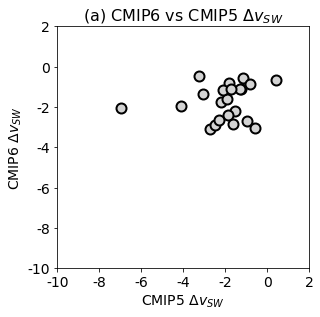

In [110]:
fig = plt.figure()
w = 7 ; h =24
fig.set_size_inches(w,h)
ax1 = fig.add_axes(np.array([0.05,0.83,0.5,0.14]))

ax1.set_xlim(-10,2)
ax1.set_ylim(-10,2)
ax1.set_xticks([-10,-8,-6,-4,-2,0,2])
ax1.set_xticklabels(['-10','-8','-6','-4','-2','0','2'], fontsize=14)
ax1.set_yticks([-10,-8,-6,-4,-2,0,2])
ax1.set_yticklabels(['-10','-8','-6','-4','-2','0','2'], fontsize=14)
ax1.set_xlabel('CMIP5 $\Delta v_{SW}$', fontsize=14)
ax1.set_ylabel('CMIP6 $\Delta v_{SW}$', fontsize=14)
ax1.set_title('(a) CMIP6 vs CMIP5 $\Delta v_{SW}$', fontsize=16)

ax1.plot(vdifcmip5,vdifcmip6,"o", markersize=10, markerfacecolor='lightgray', markeredgecolor='black', markeredgewidth=2)

In [111]:
ax2 = fig.add_axes(np.array([0.65,0.83,0.17,0.14]))

corval = np.corrcoef(vdifcmip5,vdifcmip6)
corval = corval[0,1]
mincor, maxcor = boot.boot_corr_ci(vdifcmip5,vdifcmip6,95)

ax2.set_xlim(0,2)
ax2.set_ylim(-0.5,1)
ax2.set_xticks([])
ax2.set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax2.set_yticklabels(['-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
#ax2.label_params(axis='y',pad=0)
ax2.set_ylabel("Correlation", fontsize=14, labelpad=-1)
ax2.set_title('(b) Cor(5,6)', fontsize=16)


ax2.bar(1,corval,color='lightgray', edgecolor='black')
ax2.plot([0,2],[0,0], color='black')
ax2.errorbar(1, corval, [[corval-mincor],[maxcor-corval]], color='black', linewidth=2, capsize=5, capthick=2)

<ErrorbarContainer object of 3 artists>

Wave amplitude histograms

In [112]:
ax3 = fig.add_axes(np.array([0.05,0.59,0.35,0.2]))

lecolor=['mediumseagreen','mediumpurple','dodgerblue','orangered','mediumvioletred']

dely=22 

ax3.set_xlim(-1.2,1.2)
ax3.set_ylim(0,dely*5)

yticks=[10, 20, dely+10, dely+20, 2*dely+10, 2*dely+20, 3*dely+10, 3*dely+20, 4*dely+10, 4*dely+20 ]
yticknames=['10','20','10','20','10','20','10','20','10','20']
xticks=[-1,-0.5,0,0.5,1]
xticknames=['-1','-0.5','0','0.5','1']

ax3.set_yticks(yticks)
ax3.set_yticklabels(yticknames, fontsize=14)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticknames, fontsize=14)
ax3.set_xlabel('$|\psi|$ (ms$^{-1}$)', fontsize=14)
ax3.set_ylabel('% of samples', fontsize=14)
ax3.set_title('(c) MMLEA, $|\psi|$', fontsize=16)

for imod in range(len(modnames)):
    ax3.bar(binedgesp[0:np.size(binedgesp)-1], histopast[:,imod], width=binedgesp[1]-binedgesp[0], bottom=(4-imod)*dely, edgecolor='black', color=lecolor[imod])
    string = '{0:6.2f}'.format(stdev_psi[imod]).strip()
    ax3.text(-1.15,(4-imod)*dely + 17.5,'$\sigma(|\psi|)$='+string, fontsize=12)

VSW difference histograms

In [113]:
ax4 = fig.add_axes(np.array([0.47,0.59,0.35,0.2]))

dely=18 

ax4.set_xlim(-3,3)
ax4.set_ylim(0,dely*5)

yticks=[8, 16, dely+8, dely+16, 2*dely+8, 2*dely+16, 3*dely+8, 3*dely+16, 4*dely+8, 4*dely+16 ]
yticknames=['8','16','8','16','8','16','8','16','8','16']
xticks=[-3,-2,-1,0,1,2,3]
xticknames=['-3','-2','-1','0','1','2','3']

ax4.set_yticks(yticks)
ax4.set_yticklabels(yticknames, fontsize=14)
ax4.set_xticks(xticks)
ax4.set_xticklabels(xticknames, fontsize=14)
ax4.set_xlabel('$\Delta V_{SW}$ (ms$^{-1}$)', fontsize=14)
ax4.set_ylabel(' ', fontsize=14)
ax4.set_title('(d) MMLEA, $\Delta V_{SW}$', fontsize=16)

for imod in range(len(modnames)):
    ax4.bar(binedgesdif[0:np.size(binedgesdif)-1], histodif[:,imod], width=binedgesdif[1]-binedgesdif[0], bottom=(4-imod)*dely, edgecolor='black', color=lecolor[imod])
    string = '{0:6.2f}'.format(stdev_vswdif[imod]).strip()
    ax4.text(-2.85,(4-imod)*dely + 14,'$\sigma(\Delta V_{SW})$='+string, fontsize=12)

In [114]:
ax5 = fig.add_axes(np.array([0.05,0.47,0.77,0.08]))


ax5.set_ylim(0,0.5)
ax5.set_xlim(-0.5,19)

ax5.set_xticks([1,4,7,10,13, 15, 16, 17, 18])
ax5.set_xticklabels(modnames+obsnamelong, rotation=40, fontsize=14, ha='right')
ax5.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax5.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5'], fontsize=14)
ax5.set_ylabel('$\sigma(|\psi|)$ (ms$^{-1}$)', fontsize=14)
ax5.set_title('(e) $\sigma(|\psi|)$', fontsize=16)

colors=lecolor+["black","black","black","black"]

for color, tick in zip(colors, ax5.xaxis.get_major_ticks()):
    tick.label1.set_color(color)
    
errordat = xr.open_dataset("../ERRORCALC/VWIND/DATA/errors_1mem.nc")
ax5.plot([-0.5,19], [errordat['sig_psi'],errordat['sig_psi']], linestyle='dotted', linewidth=3, color='black')

for imod in range(len(modnames)):
    ax5.bar(imod*3+1, stdev_psi[imod], width=1, bottom=0, edgecolor='black', color=lecolor[imod])
    ax5.errorbar(imod*3+1, stdev_psi[imod], [[stdev_psi[imod] - mincistdev[imod]], [maxcistdev[imod] - stdev_psi[imod]]], linewidth=2, capsize=5, capthick=2, color='black')
    ax5.errorbar(imod*3+1.9, stdev_psi[imod], [[stdev_psi[imod] - mincistdevboot[imod]], [maxcistdevboot[imod] - stdev_psi[imod]]],
                linewidth=2, capsize=5, capthick=2, color=lecolor[imod])
    
for iobs in range(len(obsname)):
    ax5.plot(15+iobs, obsstd[iobs], marker='o', color='black', markersize=12)


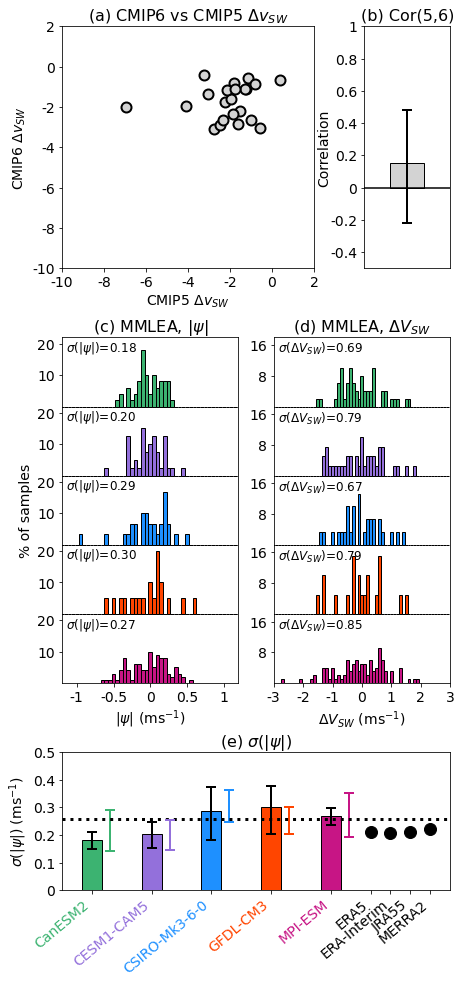

In [115]:
fig.patch.set_facecolor('white')
fig
#fig.savefig('fig4.png', facecolor='white', bbox_inches='tight')